In [115]:
import psycopg2
from psycopg2 import OperationalError

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import HTML

***
    
    Ligação à base de dados

***

In [116]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

***

    Executar este comando quando ocorrer um erro ao tentar realizar uma query

***

In [117]:
cur.execute('''ROLLBACK;''')

***

# Exploração do Data Set

***

    Nome das colunas

In [118]:
def col_names(table):
    '''
    Função que retorna os nomes das colunas de uma tabela
    
    Parâmetros : 
        - table : tabela de interesse

    return : 
        - pandas DataFrame : nomes das colunas
    '''

    cur = conn.cursor()
    cur.execute('''
                SELECT column_name
                FROM information_schema.columns
                WHERE table_name = %s;''', (table,))

    cnames = pd.DataFrame(cur.fetchall())
    #cnames = [row[0] for row in cur.fetchall()]
    return cnames

HTML(pd.DataFrame(col_names('contratos')).to_html(index=True))

,0
0,id
1,n_anuncio
2,anuncio_preco_base
3,anuncio_proposalDeadline
4,anuncio_cnccs
5,anuncio_contractingProcedureAliasID
6,anuncio_contractingProcedureId
7,anuncio_drPublicationDate
8,anuncio_dreNumber
9,anuncio_dreSeries


    Número de Contratos


In [119]:
def n_contracts(table):
    '''
    Retorna o número de contratos de uma tabela pertencente à base de dados

    Parâmetros : 
        - table : tabela de interesse

    return : 
        - int : número de contrato
    '''
    
    cur = conn.cursor()
    cur.execute('''
                SELECT COUNT(*) 
                FROM "{}"; '''.format(table))
    ncontract = cur.fetchone()[0]
    return ncontract

n_contracts("contratos")

10440

    Organizar Contratos por Tipo de Procedimento

In [120]:
cur = conn.cursor()
cur.execute('''
        SELECT tipo_procedimento, COUNT (tipo_procedimento)
        FROM "contratos"
        GROUP BY "tipo_procedimento"
        ORDER BY COUNT(tipo_procedimento) DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Ajuste Direto Regime Geral,4718
Consulta Prévia,2083
Concurso público,1990
Ao abrigo de acordo-quadro (art.º 259.º),1210
Ao abrigo de acordo-quadro (art.º 258.º),289
Ajuste direto simplificado,59
Concurso limitado por prévia qualificação,33
Consulta Prévia Simplificada,28
"Ajuste direto simplificado ao abrigo da Lei n.º 30/2021, de 21.05",20
Procedimento de negociação,4


In [121]:
cur = conn.cursor()

cur.execute('''
        SELECT "contractTypes", COUNT ("contractTypes")
        FROM "contratos"
        WHERE tipo_procedimento = 'Ajuste Direto Regime Geral'
        GROUP BY "contractTypes"
        ORDER BY  COUNT("contractTypes") DESC;;''')

df = (pd.DataFrame(cur.fetchall()))
HTML(df.to_html(index=False))

0,1
Aquisição de serviços,2377
Aquisição de bens móveis,2042
Empreitadas de obras públicas,209
Locação de bens móveis,36
Aquisição de serviços<br/>Aquisição de bens móveis,28
Aquisição de bens móveis<br/>Aquisição de serviços,13
Locação de bens móveis<br/>Aquisição de serviços,3
Concessão de obras públicas,2
Aquisição de serviços<br/>Empreitadas de obras públicas,2
Aquisição de serviços<br/>Sociedade,2


***

# Funções


***

    ID's dos contratos

In [122]:
def all_ids(table):
    '''
    Função que retorna todos os ids dos contratos de uma tabela

    Parâmetros :    
        - table : tabela de interesse

    Return : 
        - list : ids de todos os contratos de uma tabela 
    '''

    cur = conn.cursor()
    cur.execute(''' 
                SELECT id
                FROM "{}"; '''.format(table)) 
    return list(cur.fetchall())


ids = all_ids("contratos")

    ID's dos diferentes tipos de procedimentos

    1. Ajuste Direto Regime Geral

In [123]:
def ajuste_dir():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Ajuste Direto Regime Geral';''')
    
    return list(cur.fetchall())

    2. Consulta Prévia

In [124]:
def consulta_prev():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Consulta Prévia';''')
    
    return list(cur.fetchall())

    3. Concurso Público

In [125]:
def concurso_pub():
    """
    """
    
    cur = conn.cursor()
    
    cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE tipo_procedimento = 'Concurso público';''')
    
    return list(cur.fetchall())

    Restringir por CPV - 72 IT services: consulting, software development, Internet and support

In [126]:
cur = conn.cursor()
cur.execute('''
            SELECT "id"
            FROM "contratos"
            WHERE cpv LIKE '72%';''')

len(cur.fetchall())

346

In [127]:
def cpv_direto(cpv):
    
    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Ajustes Diretos em Regime Geral

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Ajuste Direto Regime Geral';''', (cpv + '%',))
    
    return cur.fetchall()

In [128]:
def cpv_cpub(cpv):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = 'Concurso público';''', (cpv + '%',))

    
    return cur.fetchall()

In [129]:
def cpv(cpv, proc):

    """
    Função que retorna os id's de todos os contratos para um determinado CPV para todos os Concursos Públicos

    Parâmetros :
        cpv : inserir os dois algarismos iniciais do CPV entre '' ( https://www.publictendering.com/cpv-codes/list-of-the-cpv-codes/ )
    
    Return :
        tuple : id's dos contratos
    """
    
    cur = conn.cursor()
    cur.execute('''
                SELECT "id"
                FROM "contratos"
                WHERE cpv LIKE %s AND tipo_procedimento = %s;''', (cpv + '%', proc))

    
    return cur.fetchall()

In [130]:
ajdir = cpv('72','Ajuste Direto Regime Geral')
cpub = cpv('72', 'Concurso público')

    Função que retorna contrato para número de id

In [131]:
def contrato(ide):
    '''
    Função que retorna linha da database referente ao contrato com id = ide
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return pd.DataFrame(cur.fetchall())


def contratos(ide):
    '''
    Função que retorna contratos referentes a um conjunto de ids

    Parâmetros :
        ide : tuplo de id's de anúncios

    return:
        dataframe com contratos
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT *
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(ide),))
    return pd.DataFrame(cur.fetchall())

    Preço contratual

In [132]:
def preco_contrato1(ide):
    '''
    Função que retorna preço contratual a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    return float(cur.fetchone()[0])



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_contrato2(ide, table = ""):
    '''
    Função que retorna preço contratual a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"
        
    cur = conn.cursor()
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))
    return float((cur.fetchone())[0])


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


#def preco_contrato3(id_anuncio):
#    
#    '''
#    Função que retorna preço contratual a partir de uma lista de ids de anúncios
#    '''
#    
#    cur.execute('''
#        SELECT preco_contratual
#        FROM "contratos"
#        WHERE id IN %s; ''', (tuple(id_anuncio),))
#    
#    return np.array(cur.fetchall()[0])

def preco_contrato3(id_anuncio):
    
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT preco_contratual
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

   #preco = list(cur.fetchall())
   #
   #n = len(preco)
   #p = np.zeros(n)

   #for i in range(n):
   #    p[i] = (preco[i][0]).replace(".", "").replace(",",".").replace("€","")

    p = np.array(cur.fetchall(), dtype = float).reshape(len(id_anuncio),)
    return p


    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    



def preco_contrato4(ide, table = ""):
    '''
    Função que retorna preço contratual a partir de uma lista de ids de anúncios para uma determinada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    
    if table == "": 
        table = "contratos"

    
    cur.execute('''
        SELECT preco_contratual
        FROM "{}"
        WHERE id IN %s; '''.format(table), (tuple(ide),))
    
    return np.asarray(cur.fetchall())
    

    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------

    Preço Base

In [133]:
def preco_base(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - tuplo : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))
    
    return cur.fetchone()



def preco_base1(ide):
    '''
    Função que retorna preço base a partir do id do anúncio para a tabela "contratos"

    Parâmetros :
        - ide : id do anúncio

    Return : 
        - int : preço contratual
    '''
        
    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id = %s; ''', (ide,))


    preco = cur.fetchone()[0]
    p1 = float(preco[:-2].replace(".", "").replace(",","."))
    
    return p1



# ---------------------------------------------------------------------------------------------------------------------------------------------------------



def preco_base2(ide, table = ""):
    '''
    Função que retorna preço base a partir do id do anúncio para um dada tabela

    Parâmetros :
        - ide : id do anúncio
        - table : tabela de interesse. Caso input esteja vazio, usar tabela 'contratos'

    Return : 
        - int : preço contratual
    '''

    if table == "": 
        table = "contratos"


    cur = conn.cursor()
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "{}"
        WHERE id = %s; '''.format(table), (ide,))


    preco = cur.fetchone()[0]

    if preco != 0:
        p1 = float(preco[:-2].replace(".", "").replace(",","."))
    else:
        p1 = 0
    
    return p1
    


# ---------------------------------------------------------------------------------------------------------------------------------------------------------
    


def preco_base3(id_anuncio):
    
    '''
    Função que retorna preço base a partir de uma lista de ids de anúncios
    '''
    
    cur.execute('''
        SELECT anuncio_preco_base
        FROM "contratos"
        WHERE id IN %s; ''', (tuple(id_anuncio),))

    preco = list(cur.fetchall())


    # Como os valores do preco base estão no formato ---.---,--€ é precio converter em -------.-- para comparar posteriormente
    n = len(preco)
    p = np.zeros(n)
    
    for i in range(n):

        if preco[i][0] != 'None':
            p[i] = (preco[i][0]).replace(".00", "").replace(".", "").replace(",",".").replace("€","")

        else:
            pass
            
    return p
    

In [134]:
## Conjunto de todos os preços base
#a = preco_base3(ids)
#
##pd.DataFrame(a).describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
#print("Nr de Zero Values :", len(a) - (np.count_nonzero(a)))
#print("Nr de Non Zero Values :", (np.count_nonzero(a)))
#print("% non zero values : ",round(np.count_nonzero(a)/len(a) * 100,1))

#nn_index = np.where(a != 0)[0]                 # índices dos ids dos contratos com preço base não nulo
#
#id1 = np.array(ids)                            # Transformação da lista de ids em array. Assim podemos extrair os ids não nulos usando os índices acima
#
#id2 = id1[nn_index]
#id2 = id2.reshape(len(id2),1)
#
#ids_nn = tuple(map(tuple, id2))                # ids não nulos. É preciso converter em tuplo para usar como input na função de preço base
#
#pb = preco_base3(ids_nn)
#pc = preco_contrato3(ids_nn)

***

    Lista de de Contratos Públicos
    
***

In [135]:
contratos(cpub)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323405,15555/2023,137670.00,6,False,6699898,13437191,2023-09-19,182,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382733
1,10322139,13241/2023,592500.00,36,False,6640568,13311154,2023-08-04,151,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699384415
2,10324626,15934/2023,150151.14,3,False,6708714,13455812,2023-09-25,186,2,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699386436
3,10270922,7447/2023,92900.00,21,False,6491309,12998447,2023-05-10,90,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699468545
4,10325177,1698/2023,1749480.72,36,False,6512074,13055482,2023-07-28,146,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699385716
5,10270503,13656/2023,97304.50,10,False,6647830,13329288,2023-08-11,156,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699474425
6,10327340,7629/2023,162500.00,9,False,6494013,13004525,2023-05-12,92,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699379417
7,10326579,13658/2023,145000.00,20,False,6648012,13329642,2023-08-11,156,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699380532
8,10270055,305/2023,118805.00,9,False,6352919,12712271,2023-07-17,137,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699474944
9,10271560,9630/2023,2304246.98,30,False,6552818,13126867,2023-06-12,112,2,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699467668


***

    Lista de Ajustes Diretos 

***

In [136]:
contratos(ajdir)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10323628,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,N/A,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382401
1,10270927,None,None,None,None,None,None,None,None,None,...,None,None,True,"Artigo 95.º, n.º 1, c), locação ou aquisição d...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699468541
2,10323670,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699382337
3,10324799,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699386139
4,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,10293265,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699547664
198,10293005,None,None,None,None,None,None,None,None,None,...,None,None,False,"Artigo 95.º, n.º 1, a), contrato de locação ou...",True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699547984
199,10292809,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699548289
200,10292748,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL 111-B/2017) ...,None,None,1699548389


***

# Flags

***

In [137]:
def redflag(pbase, pcontr, tol, ids, r):
    
    """
    Função que calcula a diferença entre o preço base e preço contratual de um contrato realizado
    Se o preço contratual estiver contido num intervalo em torno do preço base é levantada um flag
    O intervalo é definido pelo parâmetro tolerância e é definido como : [preço_base - preço_base*tolerância, preço_base + preço_base*tolerância]
    Se o preço base não estiver definido, é levantada uma flag também 

    Parâmetros de entrada : 
        pbase : array com os preços base
        pcontr : array com os preços contratuas
        tol : valor da tolerância. Só pode tomar valores entre 0 e 1
        ids : id's dos contratos em questão
        r : ratio máximo permitido entre preço base / preço contratual

    Return : 
        f : tuplo com os id's dos contratos com flag associada
    """

    # Garantir que dimensão dos arrays com os preços é igual
    if len(pbase) != len(pcontr):
        return "Error : dim pbase != dim pcontr"

    # Garantir que tolerância é um numero entre 0 e 1
    if tol < 0 or tol > 1 :
        return "Error : tolerance must belong between 0 and 1"

    # Número de preços base
    n = len(pbase)

    # Array que guarda ocorrência - ou não - de uma flag
    flags = np.zeros(n)

    for i in range(n):

        # Definir limites superior e inferior, respetivamente
        up_lim = pbase[i] * (1 + tol)
        lo_lim = pbase[i] * (1 - tol)
        ratio = pbase[i] / pcontr[i]
        
        if lo_lim < pcontr[i] < up_lim :
            flags[i] = 1
            
        if pbase[i] == 0 :
            flags[i] = 1    

        if  ratio > r :
            flags[i] = 1
            
    # Conversão do tuplo de ids num array de uma coluna
    ids = np.array(ids).reshape((n,))

    # Contratos com ocorrência de uma flag
    pos = np.where(flags != 0)

    # Selecionar contratos onde ocorre flag
    f = ids[pos]

    # Conversão do conjunto de contratos em tuplo para poder usar como input nas funções que têm como input id's de contratos
    f = f.reshape((len(f),1))
    f = tuple(map(tuple,f))
    
    return f

In [193]:
def redflag2(t,ids):
    
    """
    Função que verifica, dentro dos ajustes diretos, se o preço contratual é superior a 20.000€
    Só funciona para Aquisição de Serviços

    Parâmetros : 
        t : dataframe com todos os ajustes diretos. Esta dataframe é o  output da função 'contratos'
        ids : id's dos contratos que dizem respeito aos ajustes diretos. Estes id's são dados pelo output da função CPV

    Return :
        tuplo : f é o conjunto de contratos onde é disparada uma flag
    """

    n = len(t)

    c = t.TipoProcedimento.unique()
    #print(c)
    
    flags = np.zeros(n)
    
    #for i in range(n):
    #    if t.TipoProcedimento[i] == 'Aquisição de serviços':
    #        if t.PrecoContratual[i] > 20000:
    #            flags[i] = 1

    prices = t.PrecoContratual
    flags[np.where(prices > 20000)] = 1
    
    # Conversão do tuplo de ids num array de uma coluna
    ids = np.array(ids).reshape((n,))

    # Contratos com ocorrência de uma flag
    pos = np.where(flags != 0)

    # Selecionar contratos onde ocorre flag
    f = ids[pos]

    # Conversão do conjunto de contratos em tuplo para poder usar como input nas funções que têm como input id's de contratos
    f = f.reshape((len(f),1))
    f = tuple(map(tuple,f))

    return f

***

# Concurso Público

***

In [138]:
# Preço Base e Preço Contratual de todos os contratos públicos realizados para CPV's começados por 72
pb = preco_base3(cpub)
pc = preco_contrato3(cpub)

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

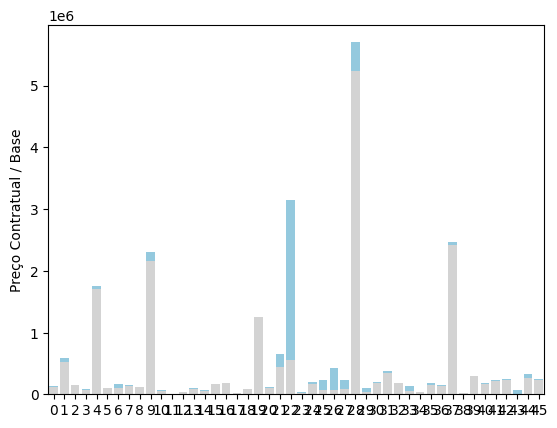

In [139]:
df = contratos(cpub).iloc[:,[2,18]]
df = df.rename(columns={2: 'PrecoBase', 18:'PrecoContratual'})
df = df.astype('float')

sns.barplot(x = df.index, y = df.PrecoBase, color = 'skyblue')
sns.barplot(x = df.index, y = df.PrecoContratual, color = 'lightgray', fill=0.1)
plt.ylabel('Preço Contratual / Base')
plt.show()

In [140]:
pb / pc

array([  1.21268657,   1.13690876,  99.81018593,   1.43297856,
       102.32569299, 100.01038086,   1.59313725,   1.09848485,
         1.        , 106.83819648,   1.21281321,   1.25659324,
         1.        ,   1.13928172,   1.16864437,   1.00000962,
         1.        ,   1.05550127,   1.00329818,   1.        ,
         1.16695362,   1.4707612 , 562.85714286,   1.26758903,
         1.19519048,   3.24786325, 544.56048738,   2.60694108,
         1.08882521,   3.35795836,   1.16287895, 111.1081881 ,
         1.00901917,   2.83518917, 111.18793854,   1.20036335,
         1.15955473, 102.30676619,   1.17857143, 100.        ,
         1.15151515, 100.43161435,   1.05000656,  32.77861826,
         1.22702796,   1.05124836])

In [141]:
redflag(pb, pc, 0.1, cpub, 20)

(('10324626',),
 ('10325177',),
 ('10270503',),
 ('10326579',),
 ('10270055',),
 ('10271560',),
 ('10271100',),
 ('10273652',),
 ('10273546',),
 ('10273533',),
 ('10273490',),
 ('10285558',),
 ('10332117',),
 ('10281794',),
 ('10281471',),
 ('10280375',),
 ('10280297',),
 ('10284270',),
 ('10286838',),
 ('10285595',),
 ('10288280',),
 ('10291509',),
 ('10290955',),
 ('10293359',))

***

# Ajuste Direto Regime Geral

***

In [194]:
ajustesdir = contratos(ajdir)
ajustesdir = ajustesdir.rename(columns={18:'PrecoContratual', 38:'TipoProcedimento'})

ajustesdir.PrecoContratual = ajustesdir.iloc[:,18].astype('float')

ajustesdir.PrecoContratual.describe().apply(lambda x: format(x, '.2f'))

count        202.00
mean       47699.19
std       248191.39
min          300.00
25%         8731.00
50%        13466.08
75%        19978.09
max      3415500.00
Name: PrecoContratual, dtype: object

In [195]:
#HTML(ajustesdir.to_html(index = False))

In [196]:
# Valor máximo de um ajuste direto é mais de 3000000€

# Índice do array do valor mais alto 
print(np.where(ajustesdir.PrecoContratual > 3000000)[0])

# ID do contrato correspondente
# ajdir[30]

HTML((contrato(ajdir[30])).to_html(index=True))

[30]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,10323555,None,None,None,None,None,None,None,None,None,None,None,None,None,Ajuste Direto Regime Geral,Locação e manutenção da plataforma de suporte ao Sistema de Informação de Pensões 2024-2026,2023-11-02,2023-11-02,3415500.00,1096,"Instituto de Informática, I. P. (504322915)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1957)","Artigo 24.º, n.º 1, alínea e), subalínea ii) do Código dos Contratos Públicos","UNISYS, S.L.U. (B-82538273)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1152098)",None,None,None,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071204&ext=.pdf,false,72200000-7,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de consultoria e de programação de software,Principal,3415500.0,2323000197 - Locação e manutenção da plataforma de suporte ao Sistema de Informação de Pensões 2024-2026,Não aplicável,None,"Portugal, Lisboa, Oeiras",Não aplicável.,Não aplicável.,None,False,False,None,None,True,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382506


In [197]:
k = 0
for i in range(len(ajustesdir)):
    
    if ajustesdir.TipoProcedimento[i] == 'Aquisição de serviços':
        #print(i, True, ajustesdir.TipoProcedimento[i])

        
        if ajustesdir.PrecoContratual[i] > 20000:
            k += 1

print(k)
    #print(ajustesdir.TipoProcedimento)

43


In [198]:
# Valores dos preços contratuais
#contratos(redflag2(ajustesdir, ajdir)).iloc[:,18]

# Ajustes Diretos com preço contratual superior a 20.000€
contratos(redflag2(ajustesdir, ajdir))

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,10326169,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385010
1,10324999,None,None,None,None,None,None,None,None,None,...,None,None,True,"Artigo 95.º, n.º 2, a), a segurança pública in...",True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699385859
2,10326178,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL 111-B/2017 )...,None,24775.00,1699384995
3,10326176,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699384999
4,10270868,None,None,None,None,None,None,None,None,None,...,None,None,True,None,True,None,Código dos Contratos Públicos (DL 111-B/2017 )...,None,None,1699468591
5,10323555,None,None,None,None,None,None,None,None,None,...,None,None,True,None,True,None,Código dos Contratos Públicos ( DL 111-B/2017 ),None,None,1699382506
6,10324032,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699387446
7,10270512,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699474406
8,10328335,None,None,None,None,None,None,None,None,None,...,None,None,False,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699378093
9,10329956,None,None,None,None,None,None,None,None,None,...,None,None,True,None,True,None,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1699448176
